In [18]:
!pip install -qU pip
!pip install -qU seaborn==0.13.1

In [12]:
import boto3
from pyathena import connect

import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
s3 = boto3.client('s3')

In [11]:
bucket_name = 'aai-540-final-data'
response = s3.list_objects_v2(Bucket=bucket_name)
for obj in response['Contents']:
    print(obj['Key'])

data/dev.tsv
data/emotions.txt
data/test.tsv
data/train.tsv
full-dataset/goemotions_1.csv
full-dataset/goemotions_2.csv
full-dataset/goemotions_3.csv


In [65]:
first_data_obj = s3.get_object(Bucket=bucket_name, Key='full-dataset/goemotions_1.csv')
second_data_obj = s3.get_object(Bucket=bucket_name, Key='full-dataset/goemotions_2.csv')
third_data_obj = s3.get_object(Bucket=bucket_name, Key='full-dataset/goemotions_3.csv')
df_1 = pd.read_csv(io.BytesIO(first_data_obj['Body'].read()))
df_2 = pd.read_csv(io.BytesIO(second_data_obj['Body'].read()))
df_3 = pd.read_csv(io.BytesIO(third_data_obj['Body'].read()))

In [72]:
df_1 = pd.read_csv('data/goemotions_1.csv')
df_2 = pd.read_csv('data/goemotions_2.csv')
df_3 = pd.read_csv('data/goemotions_3.csv')
df_1.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [94]:
if df_3['admiration'].isna().any():
    print("There are non-integer values in the 'admiration' column.")
else:
    print("All values in the 'admiration' column are integers.")

All values in the 'admiration' column are integers.


In [81]:
import csv
dfs = [df_1, df_2, df_3]

for i, df in enumerate(dfs):
    df['text'] = df['text'].str.replace(',', '')
    local_file_path = f'/tmp/goemotions_{i + 1}.csv'
    s3_file_path = f'full-dataset/goemotions_{i + 1}.csv'

    # Save to CSV without extra quoting
    df.to_csv(local_file_path, index=False, quoting=csv.QUOTE_NONNUMERIC)

    # Upload to S3
    s3.upload_file(local_file_path, bucket_name, s3_file_path)

In [17]:
region = 'us-west-2'
conn = connect(s3_staging_dir=f"s3://{bucket_name}/athena/results", region_name=region)

In [26]:
database_name = 'emotions_database'
cursor = conn.cursor()
statement = f"CREATE DATABASE IF NOT EXISTS {database_name}"
cursor.execute(statement)

In [83]:
table_name = 'emotions_table'
create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    text string,
    id string,
    author string,
    subreddit string,
    link_id string,
    parent_id string,
    created_utc bigint,
    rater_id int,
    example_very_unclear boolean,
    admiration int,
    amusement int,
    anger int,
    annoyance int,
    approval int,
    caring int,
    confusion int,
    curiosity int,
    desire int,
    disappointment int,
    disapproval int,
    disgust int,
    embarrassment int,
    excitement int,
    fear int,
    gratitude int,
    grief int,
    joy int,
    love int,
    nervousness int,
    optimism int,
    pride int,
    realization int,
    relief int,
    remorse int,
    sadness int,
    surprise int,
    neutral int
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
LOCATION 's3://{bucket_name}/full-dataset'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

try:
    # Print the database and table names
    print(f"Database: {database_name}, Table: {table_name}")

    # Execute the create table query
    cursor.execute(create_table_query)
    print("Table created successfully.")
except Exception as e:
    print("Error creating table:", e)

Database: emotions_database, Table: emotions_table
Table created successfully.


In [82]:
drop_table = f"DROP TABLE IF EXISTS {database_name}.{table_name};"
cursor.execute(drop_table)

In [98]:
COMPARE_RATERS = f"""
SELECT id,
SUM(admiration),
SUM(amusement),
SUM(anger),
SUM(annoyance),
SUM(approval),
SUM(caring),
SUM(confusion),
SUM(curiosity),
SUM(desire),
SUM(disappointment),
SUM(disapproval),
SUM(disgust),
SUM(embarrassment),
SUM(excitement),
SUM(fear),
SUM(gratitude),
SUM(grief),
SUM(joy),
SUM(love),
SUM(nervousness),
SUM(optimism),
SUM(pride),
SUM(realization),
SUM(relief),
SUM(remorse),
SUM(sadness),
SUM(surprise),
SUM(neutral)
FROM {database_name}.{table_name}
GROUP BY id
HAVING SUM(admiration) > 1 OR
       SUM(amusement) > 1 OR
       SUM(anger) > 1 OR
       SUM(annoyance) > 1 OR
       SUM(approval) > 1 OR
       SUM(caring) > 1 OR
       SUM(confusion) > 1 OR
       SUM(curiosity) > 1 OR
       SUM(desire) > 1 OR
       SUM(disappointment) > 1 OR
       SUM(disapproval) > 1 OR
       SUM(disgust) > 1 OR
       SUM(embarrassment) > 1 OR
       SUM(excitement) > 1 OR
       SUM(fear) > 1 OR
       SUM(gratitude) > 1 OR
       SUM(grief) > 1 OR
       SUM(joy) > 1 OR
       SUM(love) > 1 OR
       SUM(nervousness) > 1 OR
       SUM(optimism) > 1 OR
       SUM(pride) > 1 OR
       SUM(realization) > 1 OR
       SUM(relief) > 1 OR
       SUM(remorse) > 1 OR
       SUM(sadness) > 1 OR
       SUM(surprise) > 1 OR
       SUM(neutral) > 1
"""

test = f"""
SELECT *
FROM {database_name}.{table_name}
LIMIT 10;
"""

test2 = f"""
SELECT admiration 
FROM {database_name}.{table_name}
WHERE TRY_CAST(admiration AS INTEGER) IS NULL;
"""
df_filtered = pd.read_sql(COMPARE_RATERS, conn)
df_filtered.head()

/tmp/ipykernel_1224/1029288951.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_filtered = pd.read_sql(COMPARE_RATERS, conn)


,id,_col1,_col2,_col3,_col4,_col5,_col6,_col7,_col8,_col9,...,_col19,_col20,_col21,_col22,_col23,_col24,_col25,_col26,_col27,_col28
0,"""edzwsvy""",0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"""ee7irj3""",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,3,0,0
2,"""edzl3ki""",0,0,0,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"""ee52tcc""",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,"""edk510s""",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [99]:
len(df_filtered)

54263

In [88]:
test2 = f"DESCRIBE {database_name}.{table_name}"
cursor.execute(test2)
schema_info = cursor.fetchall()

In [89]:
print(schema_info)

[('text                \tstring              \t                    ',), ('id                  \tstring              \t                    ',), ('author              \tstring              \t                    ',), ('subreddit           \tstring              \t                    ',), ('link_id             \tstring              \t                    ',), ('parent_id           \tstring              \t                    ',), ('created_utc         \tbigint              \t                    ',), ('rater_id            \tint                 \t                    ',), ('example_very_unclear\tboolean             \t                    ',), ('admiration          \tint                 \t                    ',), ('amusement           \tint                 \t                    ',), ('anger               \tint                 \t                    ',), ('annoyance           \tint                 \t                    ',), ('approval            \tint                 \t                    ',), ('car

In [29]:
test_data_obj = s3.get_object(Bucket=bucket_name, Key='data/test.tsv')
test_df = pd.read_csv(io.BytesIO(test_data_obj['Body'].read()), delimiter='\t')

dev_data_obj = s3.get_object(Bucket=bucket_name, Key='data/dev.tsv')
val_df = pd.read_csv(io.BytesIO(dev_data_obj['Body'].read()), delimiter='\t')

In [2]:
len(test_df)

5427

In [21]:
# initial data exploration

# Calculating text length in terms of words and characters
word_count = train_df['text'].apply(lambda x: len(str(x).split()))
char_count = train_df['text'].apply(lambda x: len(str(x)))

# Calculating the average word length
def avg_word(sentence):
    words = sentence.split()
    return sum(len(word) for word in words)/len(words)

avg_word_len = train_df['text'].apply(lambda x: avg_word(x))

# Word frequency
freq = pd.Series(' '.join(train_df['text']).split()).value_counts()[:20]

# Display basic statistics and the most frequent words
print('Word Count: ', word_count.describe())
print('Character Count: ', char_count.describe())
print('Average Word Length: ', avg_word_len.describe())
print('Most Frequent Words: ', freq)

Word Count:  count    43410.000000
mean        12.840175
std          6.701597
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: text, dtype: float64
Character Count:  count    43410.000000
mean        68.400875
std         36.721898
min          2.000000
25%         38.000000
50%         65.000000
75%         96.000000
max        703.000000
Name: text, dtype: float64
Average Word Length:  count    43410.000000
mean         4.473930
std          0.943552
min          1.000000
25%          3.950000
50%          4.357143
75%          4.846154
max         49.285714
Name: text, dtype: float64
Most Frequent Words:  the       16294
I         14933
to        12267
a         11920
and        8186
is         7799
you        7002
of         6955
that       6322
[NAME]     5743
for        5459
in         5459
it         5162
this       4330
was        3764
be         3398
on         3309
my         3129
have       3107
like       3

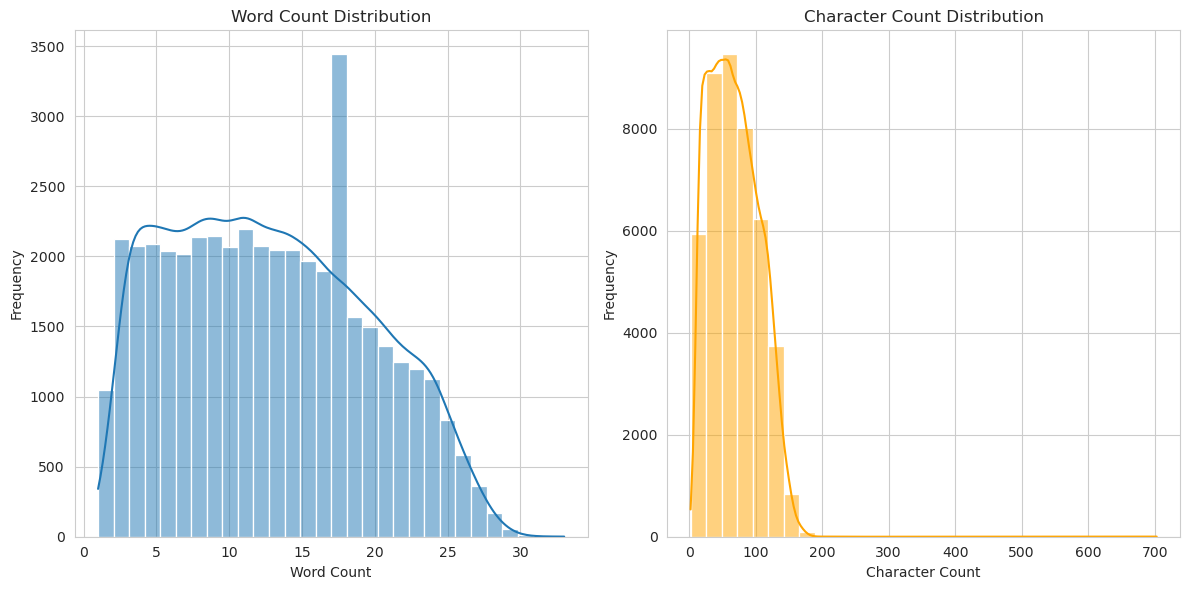

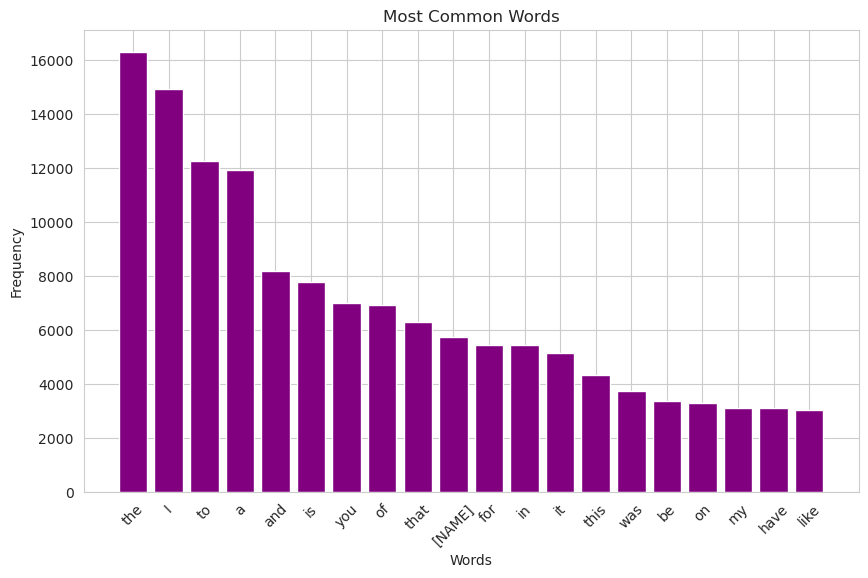

In [22]:
# Setting up the aesthetics for the plots
sns.set_style("whitegrid")

# Plot for Text Length Distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(word_count, bins=30, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(char_count, bins=30, kde=True, color='orange')
plt.title('Character Count Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Bar plot for most common words
most_common_words = dict(freq)
plt.figure(figsize=(10, 6))
plt.bar(most_common_words.keys(), most_common_words.values(), color='purple')
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_20/2509304997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotions', data=train_df, palette='mako')


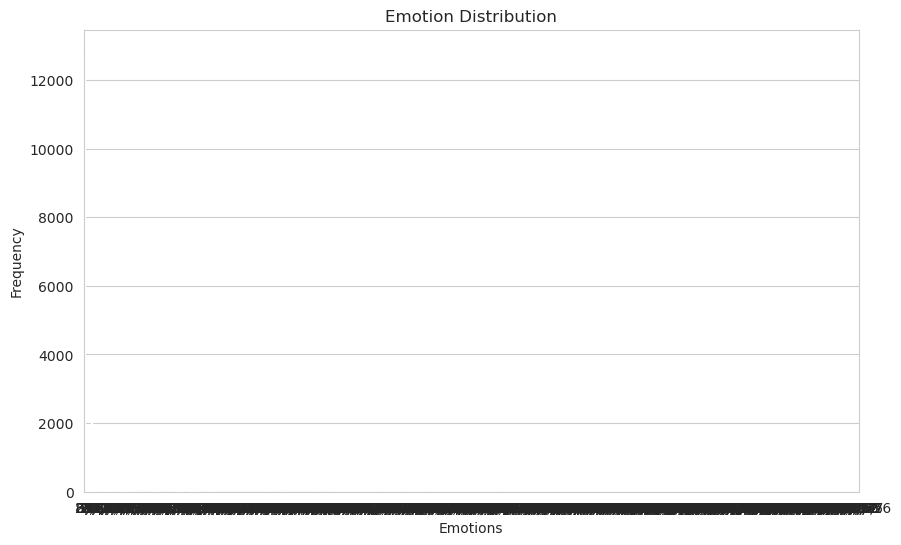

In [23]:
# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotions', data=train_df, hue='mako')
plt.title('Emotion Distribution')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.show()

In [26]:
train_df['emotions'].value_counts()

emotions
27          12823
0            2710
4            1873
15           1857
1            1652
            ...  
11,13           1
0,5,20          1
9,20,25         1
13,17,21        1
8,11,18         1
Name: count, Length: 711, dtype: int64

In [28]:
# Loading the file with emotion label names
emotion_labels_obj = s3.get_object(Bucket=bucket_name, Key='data/emotions.txt')
emotion_labels_data = emotion_labels_obj['Body'].read()

# Converting the data from bytes to string and splitting by lines
emotion_labels = emotion_labels_data.decode('utf-8').splitlines()

In [30]:
# Split emotions column to get count of each emotion individually
split_emotions = train_df['emotions'].astype(str).str.split(',')

In [52]:
all_emotions = split_emotions.explode().astype(int)

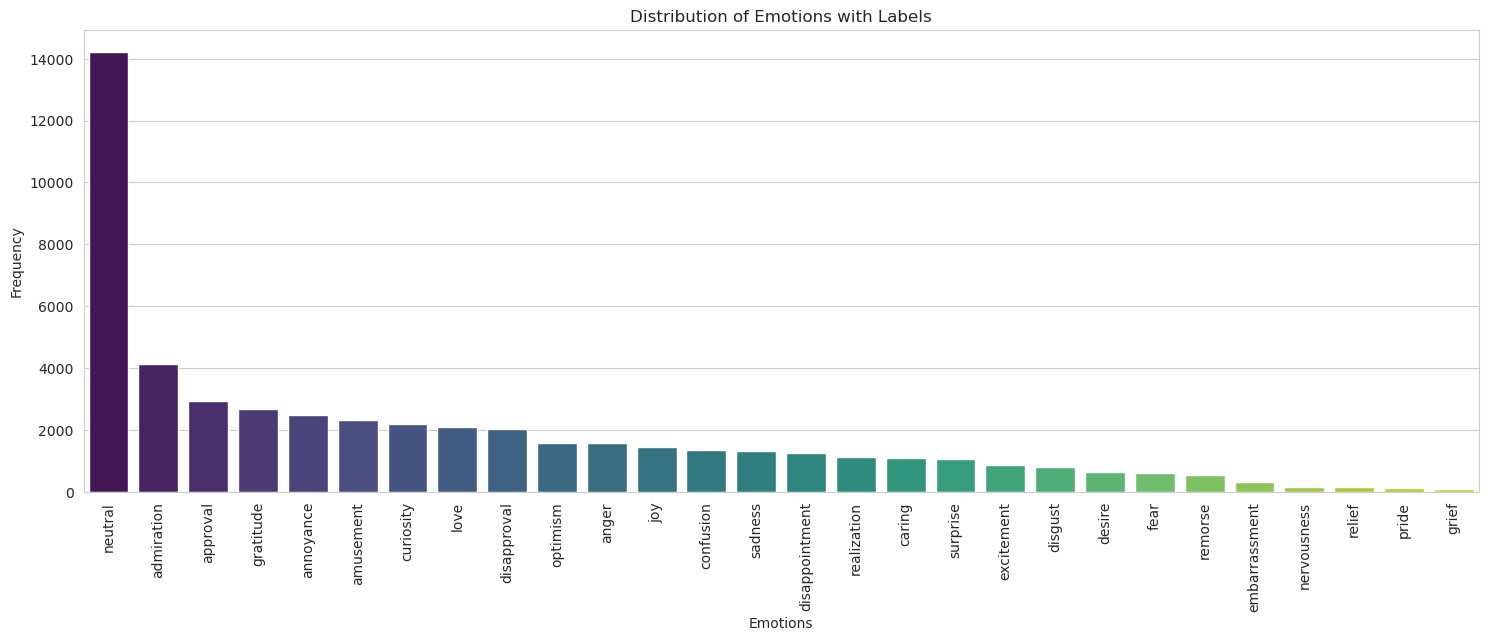

In [53]:
# Creating a mapping of indices to emotion labels
emotion_index_to_label = {index: label for index, label in enumerate(emotion_labels)}

# Applying the mapping to the emotions dataset
labeled_emotions = all_emotions.map(emotion_index_to_label)

# Counting occurrences of each emotion label
labeled_emotion_counts = labeled_emotions.value_counts()

# Plotting the distribution of emotions with correct labels and data
plt.figure(figsize=(18, 6))
sns.barplot(x=labeled_emotion_counts.index, y=labeled_emotion_counts.values, hue=labeled_emotion_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Emotions with Labels')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


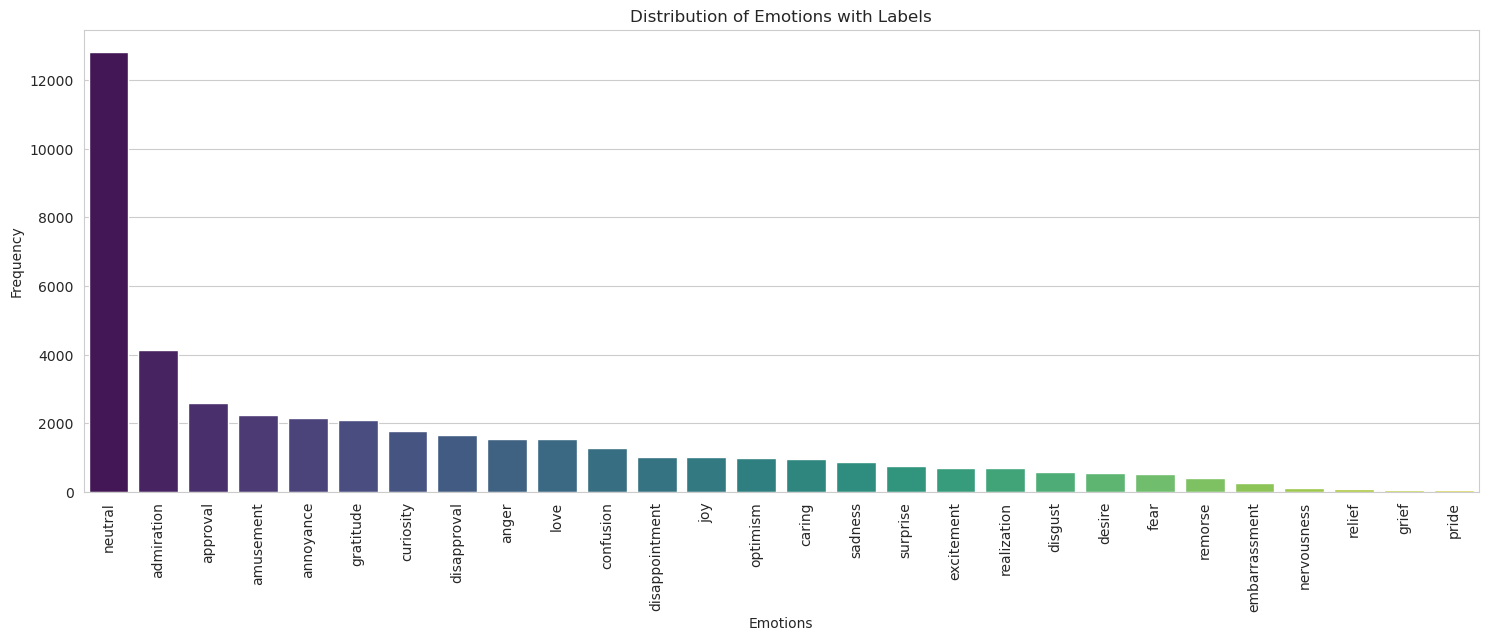

In [43]:
# Extracting only the first emotion label from each row
first_emotions = train_df['emotions'].astype(str).str.split(',').str[0].astype(int)

# Applying the mapping to the emotions dataset
labeled_first_emotions = first_emotions.map(emotion_index_to_label)

# Counting occurrences of each emotion label
labeled_first_emotion_counts = labeled_first_emotions.value_counts()

# Plotting the distribution of emotions with correct labels and data
plt.figure(figsize=(18, 6))
sns.barplot(x=labeled_first_emotion_counts.index, y=labeled_first_emotion_counts.values, hue=labeled_first_emotion_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Emotions with Labels')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [56]:
labeled_emotion_counts

emotions
neutral           14219
admiration         4130
approval           2939
gratitude          2662
annoyance          2470
amusement          2328
curiosity          2191
love               2086
disapproval        2022
optimism           1581
anger              1567
joy                1452
confusion          1368
sadness            1326
disappointment     1269
realization        1110
caring             1087
surprise           1060
excitement          853
disgust             793
desire              641
fear                596
remorse             545
embarrassment       303
nervousness         164
relief              153
pride               111
grief                77
Name: count, dtype: int64

In [73]:
emotion_categories = {
    'Affectionate Emotions': ['love', 'caring', 'admiration', 'approval'],
    'Joyful and Entertaining Emotions': ['amusement', 'joy', 'excitement', 'optimism'],
    'Reflective and Thoughtful Emotions': ['curiosity', 'realization', 'relief', 'desire'],
    'Negative Reactive Emotions': ['annoyance', 'anger', 'disgust', 'fear'],
    'Discontented Emotions': ['disapproval', 'disappointment', 'sadness', 'remorse', 'embarrassment'],
    'Complex or Ambiguous Emotions': ['confusion', 'surprise', 'pride', 'grief', 'nervousness'],
    'Introspective Emotions': ['gratitude', 'relief', 'remorse'],
    'Neutral': ['neutral']
}


emotion_to_category = {}
for category, emotions in emotion_categories.items():
    for emotion in emotions:
        emotion_to_category[emotion] = category

category_counts = pd.Series(dtype=int).reindex(emotion_categories.keys(), fill_value=0)

for emotion, count in labeled_emotion_counts.items():
    category = emotion_to_category[emotion]
    if category:
        category_counts[category] += count
        
category_counts

Affectionate Emotions                 10242
Joyful and Entertaining Emotions       6214
Reflective and Thoughtful Emotions     3942
Negative Reactive Emotions             5426
Discontented Emotions                  4920
Complex or Ambiguous Emotions          2780
Introspective Emotions                 3360
Neutral                               14219
dtype: int64

In [70]:
emotion_to_category

{'Love': 'Affectionate Emotions',
 'Caring': 'Affectionate Emotions',
 'Admiration': 'Affectionate Emotions',
 'Approval': 'Affectionate Emotions',
 'Amusement': 'Joyful and Entertaining Emotions',
 'Joy': 'Joyful and Entertaining Emotions',
 'Excitement': 'Joyful and Entertaining Emotions',
 'Optimism': 'Joyful and Entertaining Emotions',
 'Curiosity': 'Reflective and Thoughtful Emotions',
 'Realization': 'Reflective and Thoughtful Emotions',
 'Relief': 'Introspective Emotions',
 'Desire': 'Reflective and Thoughtful Emotions',
 'Annoyance': 'Negative Reactive Emotions',
 'Anger': 'Negative Reactive Emotions',
 'Disgust': 'Negative Reactive Emotions',
 'Fear': 'Negative Reactive Emotions',
 'Disapproval': 'Discontented Emotions',
 'Disappointment': 'Discontented Emotions',
 'Sadness': 'Discontented Emotions',
 'Remorse': 'Introspective Emotions',
 'Embarrassment': 'Discontented Emotions',
 'Pride': 'Socially-Driven Emotions',
 'Grief': 'Socially-Driven Emotions',
 'Nervousness': 'Socia

In [102]:
column_names = ['text', 'emotions', 'id']
train_data_obj = s3.get_object(Bucket=bucket_name, Key='data/train.tsv')
train_df = pd.read_csv(io.BytesIO(train_data_obj['Body'].read()), delimiter='\t', header=None, names=column_names)

train_df.head(20)

,text,emotions,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26,edvnz26
6,Yes I heard abt the f bombs! That has to be wh...,15,ee3b6wu
7,We need more boards and to create a bit more s...,"8,20",ef4qmod
8,Damn youtube and outrage drama is super lucrat...,0,ed8wbdn
9,It might be linked to the trust factor of your...,27,eczgv1o


In [104]:
train_df['emotions'].value_counts().head(35)

emotions
27       12823
0         2710
4         1873
15        1857
1         1652
3         1451
18        1427
10        1402
7         1389
2         1025
20         861
6          858
17         853
25         817
26         720
9          709
5          649
22         586
13         510
11         498
14         430
8          389
24         353
2,3        230
0,15       227
12         203
0,4        199
4,27       190
6,7        174
0,18       155
3,10       148
3,27       123
10,27      104
9,25       103
7,27       102
Name: count, dtype: int64